In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from krawtchouk_moments import krawtchouk_moments

## Load Data

In [2]:
DATA_DIR = '/Users/kx/Docs/github/git_cccr_sl/chinese-calligraphy-recognition-sl/data/cccr'
chars = [x[-2] for x in glob.glob(DATA_DIR + '/train/*/')]

In [3]:
N, M = 128, 128

def read_data(data_dir):
    images = np.zeros((len(glob.glob(data_dir + '/*/*/*.png')), N, M))
    labels = np.zeros(len(images), dtype='int')

    i = 0
    for folder in glob.glob(data_dir + '/*/'):
        tmp = folder.split('/')
        char = tmp[-2]
        label = np.where(np.array(chars) == char)[0][0]
        for file in glob.glob(data_dir + '/{}/*/*.png'.format(char)):
            img = cv2.resize(cv2.imread(file), (M, N))[:, :, 0]
            images[i, :, :] = img
            labels[i] = label
            i += 1
            
    return images, labels

imgs_train, y_train = read_data(os.path.join(DATA_DIR, 'train_augmented'))
imgs_valid, y_valid = read_data(os.path.join(DATA_DIR, 'validation'))
imgs_test, y_test = read_data(os.path.join(DATA_DIR, 'test'))

## Moments extraction

In [4]:
def extract_moments(images, N, M, N_order, M_order, p):
    N, M = images[0].shape
    km = np.zeros(images.shape)
    for i in tqdm(range(len(images))):
        resized = cv2.resize(images[i], (N, M))
        resized = (resized > resized.max() / 2 - (resized.max()/ 100)).astype('int')
        km[i, :, :] = krawtchouk_moments(resized, N, M, p)

    km = km[:, :N_order, :M_order]
    km = km.reshape((len(km), N_order * M_order))
    return km


N, M = 32, 32
N_order, M_order = 32, 32
p = [0.5, 0.5]
km_train = extract_moments(imgs_train, N, M, N_order, M_order, p)
km_valid = extract_moments(imgs_valid, N, M, N_order, M_order, p)
km_test = extract_moments(imgs_test, N, M, N_order, M_order, p)

  0%|          | 0/15875 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
def coord_to_idx(a, b):
    return M_order * a + b

def idx_to_coord(idx):
    return (idx // M_order, idx % N_order)

## t-SNE Visualisation

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

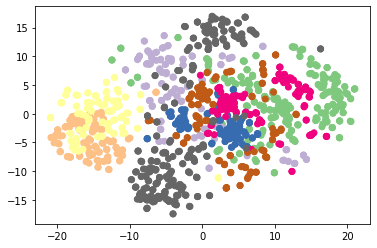

In [7]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_res = tsne.fit_transform(km_train[y_train < 10])
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y_train[y_train < 10], cmap='Accent')

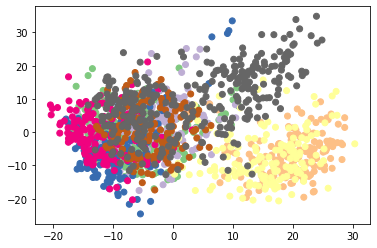

In [9]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(km_train[y_train < 10])
plt.scatter(pca_res[:,0], pca_res[:,1], c=y_train[y_train < 10], cmap='Accent')

In [10]:
i = 9
dists = ((km_train - km_train[i]) ** 2).sum(axis=1) // 1e7
[chars[label] for label in y_train[dists.argsort()[1:]]]

['行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '所',
 '行',
 '所',
 '所',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '行',
 '所',
 '所',
 '行',
 '行',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '行',
 '行',
 '行',
 '行',
 '行',
 '地',
 '行',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地',
 '地'

## Feature Selection

In [11]:
from sklearn.feature_selection import mutual_info_classif

In [12]:
mutual_info = mutual_info_classif(km_train, y_train)

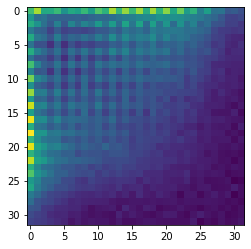

In [13]:
plt.imshow(mutual_info.reshape((N_order, M_order)))

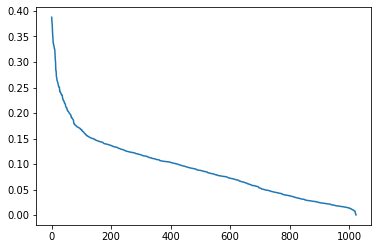

In [16]:
plt.plot(sorted(mutual_info, reverse=True))

In [15]:
selected = (-mutual_info).argsort()[:400]
# selected = (-mutual_info).argsort()[:600]
[idx_to_coord(i) for i in selected]

[(18, 0),
 (16, 0),
 (20, 0),
 (14, 0),
 (22, 0),
 (0, 12),
 (0, 1),
 (0, 18),
 (0, 16),
 (12, 0),
 (0, 14),
 (0, 20),
 (10, 0),
 (0, 22),
 (24, 0),
 (0, 10),
 (8, 0),
 (0, 0),
 (0, 15),
 (0, 4),
 (0, 8),
 (0, 13),
 (19, 0),
 (0, 19),
 (0, 24),
 (0, 11),
 (21, 0),
 (23, 0),
 (0, 17),
 (17, 0),
 (2, 0),
 (6, 0),
 (0, 3),
 (0, 2),
 (0, 6),
 (4, 0),
 (0, 21),
 (26, 0),
 (2, 14),
 (2, 16),
 (20, 1),
 (22, 1),
 (0, 7),
 (15, 0),
 (2, 18),
 (0, 9),
 (0, 26),
 (2, 12),
 (0, 23),
 (25, 0),
 (13, 0),
 (22, 2),
 (2, 10),
 (1, 0),
 (18, 1),
 (21, 1),
 (18, 2),
 (2, 20),
 (24, 1),
 (20, 2),
 (1, 19),
 (2, 22),
 (0, 5),
 (2, 1),
 (11, 0),
 (1, 21),
 (19, 1),
 (1, 22),
 (1, 20),
 (16, 2),
 (4, 12),
 (4, 18),
 (16, 1),
 (1, 17),
 (4, 14),
 (1, 16),
 (1, 18),
 (23, 1),
 (1, 23),
 (14, 2),
 (10, 1),
 (6, 12),
 (25, 1),
 (2, 6),
 (24, 2),
 (20, 4),
 (2, 8),
 (6, 14),
 (16, 4),
 (2, 24),
 (9, 0),
 (4, 20),
 (22, 3),
 (14, 1),
 (21, 2),
 (8, 1),
 (2, 4),
 (6, 1),
 (1, 15),
 (0, 25),
 (1, 24),
 (4, 16),
 (

## Classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
X_train = km_train[:, selected]
X_valid = km_valid[:, selected]
X_test = km_test[:, selected]

In [19]:
knn = KNeighborsClassifier(
    n_neighbors=len(X_train), 
    metric='euclidean', 
    weights='uniform'
)
knn.fit(X_train, y_train)
dist, neighbour_idx = knn.kneighbors(X_valid)

In [20]:
k = 3
dist_nearest, i_nearest = dist[:, :k], neighbour_idx[:, :k]
dist_furthest, i_furthest = dist[:, -1:], neighbour_idx[:, -1:]

weights = (dist_furthest - dist_nearest) / (dist_furthest[:, :1] - dist_nearest[:, :1])
get_weights = lambda dist: weights

knn = KNeighborsClassifier(
    n_neighbors=k, 
    metric='euclidean', 
    weights=get_weights
)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)

In [21]:
(y_pred == y_valid).sum() / y_valid.shape[0]

0.793

### Analysis of Results

<AxesSubplot:>

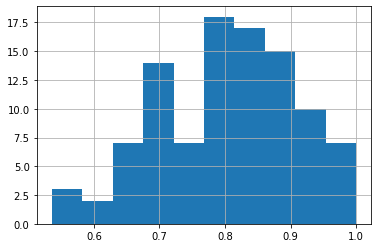

In [57]:
df = pd.DataFrame({
    'class': y_pred,
    'correct': y_valid == y_pred
})
df = df.groupby('class').agg(['count', 'sum'])['correct']
df['acc'] = df['sum'] / df['count']
df['acc'].hist()

In [55]:
[(chars[i], round(df['acc'][i], 2)) for i in df['acc'].sort_values().index][:20]

[('一', 0.54),
 ('去', 0.55),
 ('地', 0.57),
 ('到', 0.61),
 ('为', 0.62),
 ('来', 0.63),
 ('如', 0.64),
 ('于', 0.65),
 ('和', 0.65),
 ('着', 0.67),
 ('发', 0.67),
 ('她', 0.67),
 ('事', 0.68),
 ('道', 0.68),
 ('作', 0.68),
 ('也', 0.69),
 ('了', 0.69),
 ('种', 0.7),
 ('以', 0.7),
 ('手', 0.71)]